In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Parameters
img_size = (128, 128)  # Adjust based on your dataset
batch_size = 16  # Reduced batch size for potential accuracy improvement


# Data Augmentation and Loading
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.2
)
validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Fake image detection dataset-20241104T095406Z-001/Fake image detection dataset/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['real', 'fake']
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Fake image detection dataset-20241104T095406Z-001/Fake image detection dataset/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['real', 'fake']
)
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Fake image detection dataset-20241104T095406Z-001/Fake image detection dataset/validation',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['real', 'fake']
)

Found 260 images belonging to 2 classes.
Found 182 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load a pretrained model with weights (without the top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers except the last 4
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)


# Compile the model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Train the model with callbacks
model.fit(train_generator, epochs=20, validation_data=validation_generator,
          callbacks=[early_stop, model_checkpoint], class_weight={0: 1.0, 1: 1.5})

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 299s 15s/step - accuracy: 0.4815 - loss: 1.0133 - val_accuracy: 0.5080 - val_loss: 0.6840
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.6452 - loss: 0.8238 - val_accuracy: 0.6880 - val_loss: 0.5690
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.8141 - loss: 0.5587 - val_accuracy: 0.7720 - val_loss: 0.5130
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.7980 - loss: 0.5086 - val_accuracy: 0.7440 - val_loss: 0.5500
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.8219 - loss: 0.4971 - val_accuracy: 0.7560 - val_loss: 0.5718
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.8654 - loss: 0.3543 - val_accuracy: 0.7800 - val_loss: 0.6419
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.8843 - loss: 0.3186 - val_accuracy: 0.7760 - val_loss: 0.7510
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.9422 - loss: 0.1675 - val_accuracy: 0.7440 - val_

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def classify_image(model, img_path):
    img = image.load_img('/content/drive/MyDrive/Fake image detection dataset-20241104T095406Z-001/Fake image detection dataset/test/fake/fake_430 - Copy.jpg', target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    return "Real" if prediction[0][0] < 0.5 else "Fake"

# Example usage
print(classify_image(model, 'path_to_image.jpg'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Fake


In [ ]:
model.save('real_vs_fake_detector2.keras')


17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 450ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 112s 10s/step


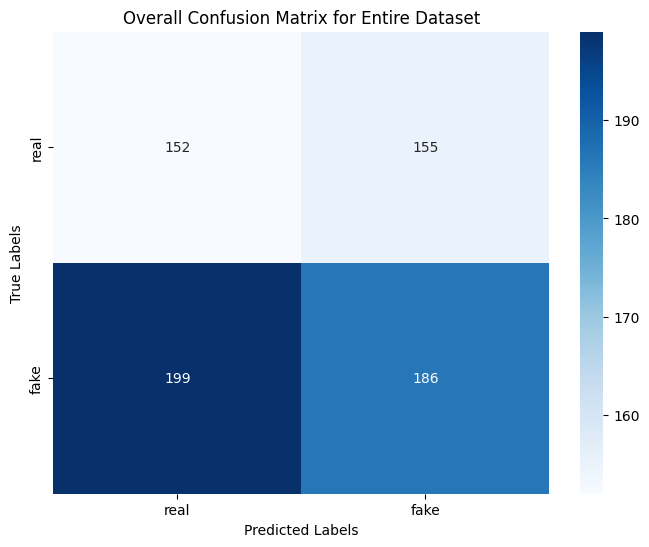

Classification Report for Entire Dataset:
               precision    recall  f1-score   support

        real       0.43      0.50      0.46       307
        fake       0.55      0.48      0.51       385

    accuracy                           0.49       692
   macro avg       0.49      0.49      0.49       692
weighted avg       0.50      0.49      0.49       692



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_overall_confusion_matrix(model, train_generator, validation_generator, test_generator):
    # Helper function to get predictions and true labels from a generator
    def get_predictions_and_labels(generator):
        generator.reset()
        predictions = model.predict(generator, steps=generator.samples // generator.batch_size + 1)
        predicted_classes = (predictions > 0.5).astype(int).flatten()
        true_classes = generator.classes
        return predicted_classes, true_classes

    # Get predictions and true labels for each set
    train_pred, train_true = get_predictions_and_labels(train_generator)
    val_pred, val_true = get_predictions_and_labels(validation_generator)
    test_pred, test_true = get_predictions_and_labels(test_generator)

    # Concatenate predictions and true labels for all sets
    overall_predictions = np.concatenate([train_pred, val_pred, test_pred])
    overall_true_labels = np.concatenate([train_true, val_true, test_true])

    # Class labels
    class_labels = list(train_generator.class_indices.keys())

    # Compute overall confusion matrix
    conf_matrix = confusion_matrix(overall_true_labels, overall_predictions)

    # Display confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Overall Confusion Matrix for Entire Dataset')
    plt.show()

    # Print classification report for precision, recall, and F1-score
    report = classification_report(overall_true_labels, overall_predictions, target_names=class_labels)
    print("Classification Report for Entire Dataset:\n", report)

# Call the function to evaluate on the overall dataset (train, validation, and test sets)
evaluate_overall_confusion_matrix(model, train_generator, validation_generator, test_generator)


In [ ]:
# Evaluate the model on the train, validation, and test sets
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
validation_loss, validation_accuracy = model.evaluate(validation_generator, verbose=1)
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

# Print accuracies for each set
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Calculate and print overall accuracy as an average
overall_accuracy = (train_accuracy + validation_accuracy + test_accuracy) / 3
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

# Call the function to evaluate with metrics, confusion matrix, and classification report for the test set
#evaluate_model_with_metrics(model, test_generator)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.9008 - loss: 0.2927
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7511 - loss: 0.5381
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.7149 - loss: 0.5999
Train Accuracy: 88.08%
Validation Accuracy: 77.20%
Test Accuracy: 71.43%
Overall Accuracy: 78.90%
